# Uncertainty Quantification and Model Limitations in Protein Language Models

**Learning Objectives:**
- Understand different sources of uncertainty in pLM predictions
- Learn to quantify and interpret prediction confidence
- Identify failure modes and limitations of pLMs
- Make informed decisions about when to trust model predictions

**Estimated Time: 30-35 minutes**


# Setup and Installation

In [1]:
# Install required packages
if 'google.colab' in str(get_ipython()):
    !pip install transformers torch biopython matplotlib seaborn pandas numpy scipy -q


import torch
from transformers import EsmTokenizer, EsmForMaskedLM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Setup complete!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.3 MB/s eta 0:00:00
Setup complete!


# Part 1: Load ESM-2 Model

In [2]:
# Load ESM-2 model and tokenizer
model_name = "facebook/esm2_t30_150M_UR50D" #MIT license
print(f"Loading {model_name}...")

tokenizer = EsmTokenizer.from_pretrained(model_name)
model = EsmForMaskedLM.from_pretrained(model_name)

# Set model to evaluation mode
model.eval()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"Model loaded successfully on {device}!")
print(f"Model has {sum(p.numel() for p in model.parameters())/1e6:.1f}M parameters")

Loading facebook/esm2_t30_150M_UR50D...


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/595M [00:00<?, ?B/s]

Model loaded successfully on cpu!
Model has 148.1M parameters


# Part 2: Test Sequences - Different Protein Types

In [3]:

# Define test sequences representing different categories
test_sequences = {
    'Antibody Heavy Chain': {
        'name': 'Cetuximab heavy chain (EGFR antibody)',
        'sequence': 'QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLEWLGVIWSGGNTDYNTPFTSRLSINKDNSKSQVFFKMNSLQSNDTAIYYCARALTYYDYEFAYWGQGTLVTVSA',
        'description': 'Well-studied antibody heavy chain, routinely engineered'
    },
    'Antibody Light Chain': {
        'name': 'Cetuximab light chain (EGFR antibody)',
        'sequence': 'DILLTQSPVILSVSPGERVSFSCRASQSIGTNIHWYQQRTNGSPRLLIKYASESISGIPSRFSGSGSGTDFTLSINSVESEDIADYYCQQNNNWPTTFGAGTKLELKR',
        'description': 'Well-studied antibody light chain, routinely engineered'
    },
    'Well-studied': {
        'name': 'Human p53 DNA-binding domain (partial)',
        'sequence': 'QKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELP',
        'description': 'Well-studied tumor suppressor, thousands of papers'
    },
    'Rare': {
        'name': 'Hypothetical protein from rare extremophile (GenBank AGVZ01000037.1)',
        'sequence': 'MKIYLLSLGAGLLVGIVYSLLNVRSPAPPVIALVGLLGILVGEQIIPLAKSLWSKEPAAVSWLQQVKPHMFGHMPKGGNSPEIAHRSQTNLEERS',
        'description': 'From poorly characterized organism'
    },
    'Disordered': {
        'name': 'Intrinsically disordered region (IDR)',
        'sequence': 'MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHS',
        'description': 'N-terminal transactivation domain of p53 (mostly disordered)'
    },
    'Random': {
        'name': 'Random amino acid sequence',
        'sequence': ''.join(np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'), size=100)),
        'description': 'Completely random, no biological meaning'
    }
}

print("Test Sequences:")
for key, info in test_sequences.items():
    print(f"\n{key}: {info['name']}")
    print(f"  Length: {len(info['sequence'])} aa")
    print(f"  Description: {info['description']}")


Test Sequences:

Antibody Heavy Chain: Cetuximab heavy chain (EGFR antibody)
  Length: 119 aa
  Description: Well-studied antibody heavy chain, routinely engineered

Antibody Light Chain: Cetuximab light chain (EGFR antibody)
  Length: 108 aa
  Description: Well-studied antibody light chain, routinely engineered

Well-studied: Human p53 DNA-binding domain (partial)
  Length: 201 aa
  Description: Well-studied tumor suppressor, thousands of papers

Rare: Hypothetical protein from rare extremophile (GenBank AGVZ01000037.1)
  Length: 95 aa
  Description: From poorly characterized organism

Disordered: Intrinsically disordered region (IDR)
  Length: 116 aa
  Description: N-terminal transactivation domain of p53 (mostly disordered)

Random: Random amino acid sequence
  Length: 100 aa
  Description: Completely random, no biological meaning


# Part 3: Calculate Perplexity - Overall Sequence Confidence

In [4]:
def calculate_perplexity(model, tokenizer, sequence):
    """
    Calculate perplexity for a protein sequence using a GPT-based model.
    Lower perplexity = model is more confident in the sequence.
    This method of perplexity calculation is prone to over-confidence on repeat sequences or other out-of-distribution sequences.
    """
    # Tokenize sequence
    inputs = tokenizer(sequence, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids'].to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    # Perplexity = exp(loss)
    perplexity = torch.exp(loss).item()

    return perplexity

def calculate_perplexity_masked(model, tokenizer, sequence):
    """
    Calculate perplexity by masking each position one at a time.
    Model only sees surrounding context, not the masked position.
    Useful for models trained with masked language modeling (MLM), e.g. BERT models.
    """
    total_loss = 0
    count = 0

    for i in range(len(sequence)):
        # Mask position i
        masked_seq = sequence[:i] + '<mask>' + sequence[i+1:]

        inputs = tokenizer(masked_seq, return_tensors='pt')
        input_ids = inputs['input_ids'].to(device)

        # Find mask position
        mask_idx = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

        # Get predictions
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[0, mask_idx]

        # Get true token
        true_token_id = tokenizer.encode(sequence[i], add_special_tokens=False)[0]

        # Calculate loss for this position
        probs = torch.softmax(logits, dim=0)
        position_loss = -torch.log(probs[true_token_id] + 1e-10)

        total_loss += position_loss.item()
        count += 1

    avg_loss = total_loss / count
    perplexity = np.exp(avg_loss)

    return perplexity

# Calculate perplexity for all test sequences
print("Calculating perplexity for test sequences...\n")

perplexity_results = []
for key, info in test_sequences.items():
    perplexity = calculate_perplexity(model, tokenizer, info['sequence'])
    masked_perplexity = calculate_perplexity_masked(model, tokenizer, info['sequence'])
    perplexity_results.append({
        'Type': key,
        'Name': info['name'],
        'Length': len(info['sequence']),
        'Perplexity': perplexity,
        'Masked Perplexity': masked_perplexity
    })
    print(f"{key:20s} - Perplexity: {perplexity:6.2f} - Masked Perplexity: {masked_perplexity:6.2f}")


Calculating perplexity for test sequences...

Antibody Heavy Chain - Perplexity:   1.26 - Masked Perplexity:   4.74
Antibody Light Chain - Perplexity:   1.28 - Masked Perplexity:   5.36
Well-studied         - Perplexity:   1.41 - Masked Perplexity:   7.25
Rare                 - Perplexity:   1.43 - Masked Perplexity:   9.59
Disordered           - Perplexity:   1.49 - Masked Perplexity:  11.02
Random               - Perplexity:   1.81 - Masked Perplexity:  22.82


**Discussion Question 1**: What is the difference between the perplexity values reported here? Why is the perplexity calculated on the full sequence much lower (better) than the masked perplexity?

**Discussion Question 2**: Why does the random sequence have such high perplexity? What does this tell us about using perplexity as a quality filter?


# Part 4: Position-Specific Confidence with Entropy

In [5]:
def calculate_positional_entropy(model, tokenizer, sequence):
    """
    Calculate entropy at each position when masked.
    Higher entropy = more uncertainty about what amino acid should be there.
    """
    entropies = []

    for i in range(len(sequence)):
        # Create masked version
        masked_seq = sequence[:i] + '<mask>' + sequence[i+1:]

        # Tokenize
        inputs = tokenizer(masked_seq, return_tensors='pt')
        input_ids = inputs['input_ids'].to(device)

        # Find mask position
        mask_idx = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

        # Get predictions
        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits[0, mask_idx]

        # Calculate probability distribution
        probs = torch.softmax(logits, dim=0).cpu().numpy()

        # Calculate entropy (only for amino acid tokens)
        aa_tokens = tokenizer.get_vocab()
        aa_indices = [aa_tokens[aa] for aa in 'ACDEFGHIKLMNPQRSTVWY' if aa in aa_tokens]
        aa_probs = probs[aa_indices]
        aa_probs = aa_probs / aa_probs.sum()  # Renormalize

        ent = entropy(aa_probs, base=2)
        entropies.append(ent)

    return np.array(entropies)

# Calculate entropy for well-studied and disordered sequences
print("Calculating position-specific entropy (this may take a minute)...\n")

# Use shorter sequences for speed
seq_abHC = test_sequences['Antibody Heavy Chain']['sequence']
seq_abLC = test_sequences['Antibody Light Chain']['sequence']

entropy_hc = calculate_positional_entropy(model, tokenizer, seq_abHC)
entropy_lc = calculate_positional_entropy(model, tokenizer, seq_abLC)

print(f"Heavy chain sequence - Mean entropy: {entropy_hc.mean():.3f} ± {entropy_hc.std():.3f}")
print(f"Light chain sequence   - Mean entropy: {entropy_lc.mean():.3f} ± {entropy_lc.std():.3f}")

seq_well_studied = test_sequences['Well-studied']['sequence']
seq_disordered = test_sequences['Disordered']['sequence']

entropy_well = calculate_positional_entropy(model, tokenizer, seq_well_studied)
entropy_dis = calculate_positional_entropy(model, tokenizer, seq_disordered)

print(f"Well-studied sequence - Mean entropy: {entropy_well.mean():.3f} ± {entropy_well.std():.3f}")
print(f"Disordered sequence   - Mean entropy: {entropy_dis.mean():.3f} ± {entropy_dis.std():.3f}")

Calculating position-specific entropy (this may take a minute)...

Heavy chain sequence - Mean entropy: 2.309 ± 1.046
Light chain sequence   - Mean entropy: 2.469 ± 1.123
Well-studied sequence - Mean entropy: 2.703 ± 1.234
Disordered sequence   - Mean entropy: 3.475 ± 0.765


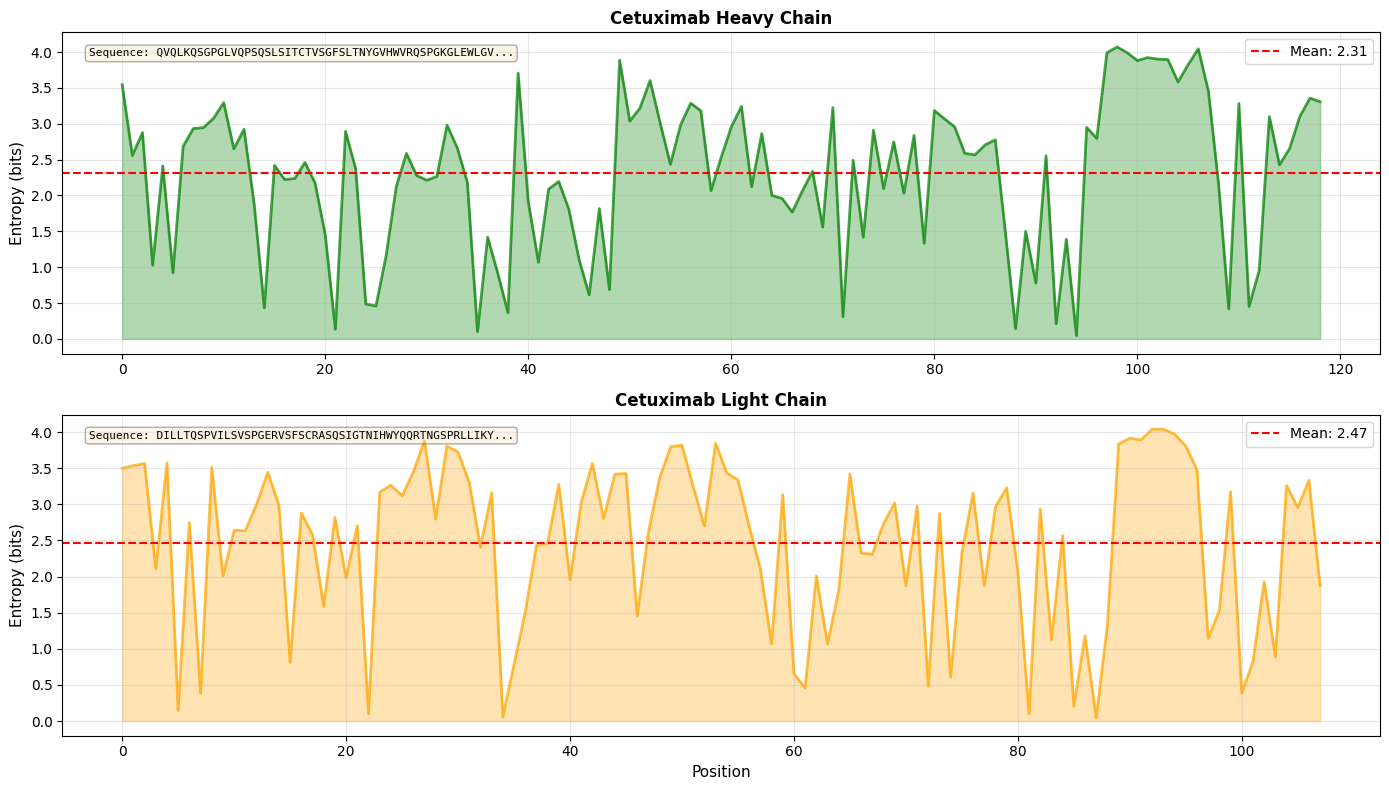

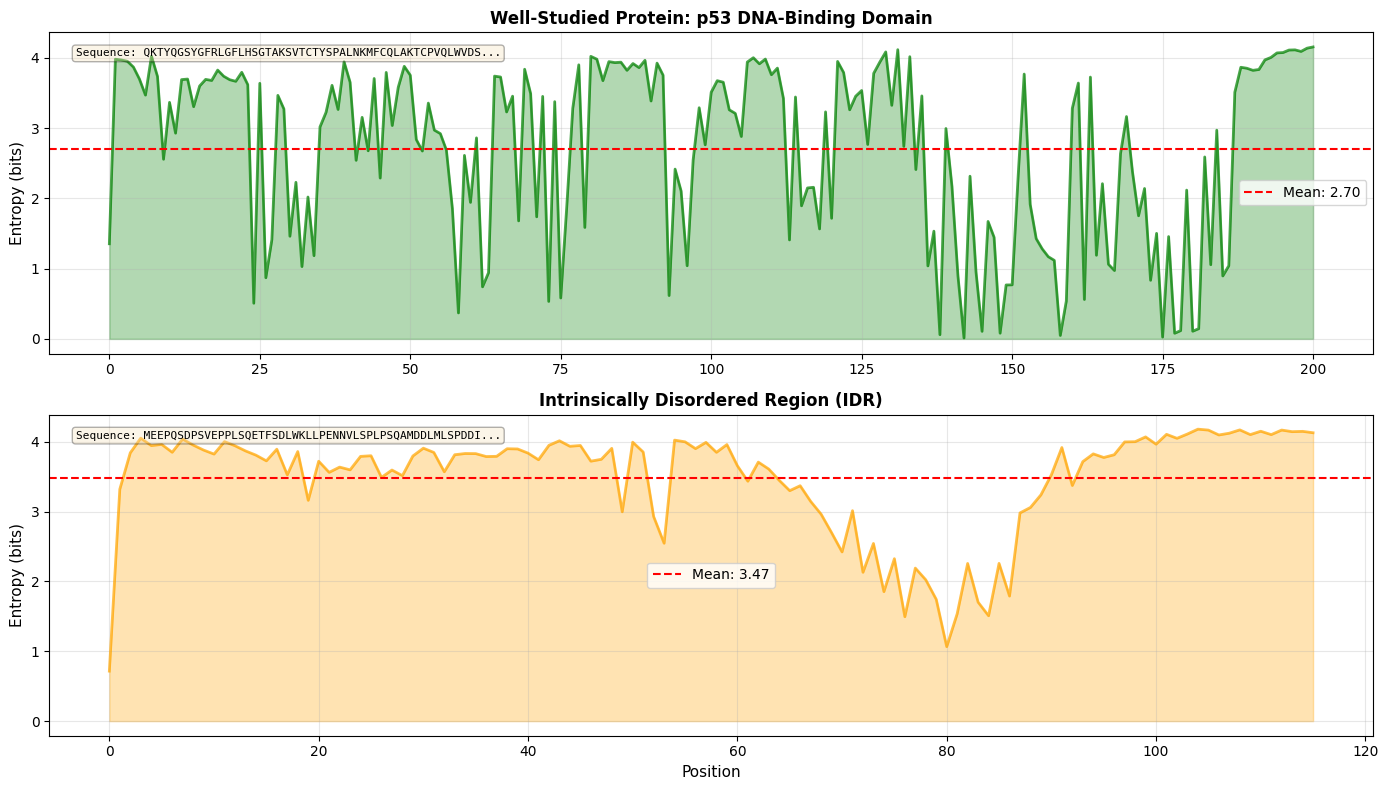


⚠️ Key Observation: Disordered regions show higher and more variable entropy!
This indicates the model is less confident about residues in flexible/disordered regions.



In [6]:

# Visualize positional entropy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Antibody heavy chain sequence
ax1.plot(entropy_hc, linewidth=2, color='green', alpha=0.7)
ax1.axhline(entropy_hc.mean(), color='red', linestyle='--', label=f'Mean: {entropy_hc.mean():.2f}')
ax1.fill_between(range(len(entropy_hc)), 0, entropy_hc, alpha=0.3, color='green')
ax1.set_ylabel('Entropy (bits)', fontsize=11)
ax1.set_title('Cetuximab Heavy Chain', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Display sequence with entropy coloring
seq_display = ''
for i, aa in enumerate(seq_abHC):
    seq_display += aa
ax1.text(0.02, 0.95, f'Sequence: {seq_display[:50]}...',
         transform=ax1.transAxes, fontsize=8, verticalalignment='top',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Disordered sequence
ax2.plot(entropy_lc, linewidth=2, color='orange', alpha=0.7)
ax2.axhline(entropy_lc.mean(), color='red', linestyle='--', label=f'Mean: {entropy_lc.mean():.2f}')
ax2.fill_between(range(len(entropy_lc)), 0, entropy_lc, alpha=0.3, color='orange')
ax2.set_xlabel('Position', fontsize=11)
ax2.set_ylabel('Entropy (bits)', fontsize=11)
ax2.set_title('Cetuximab Light Chain', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

seq_display2 = ''
for i, aa in enumerate(seq_abLC):
    seq_display2 += aa
ax2.text(0.02, 0.95, f'Sequence: {seq_display2[:50]}...',
         transform=ax2.transAxes, fontsize=8, verticalalignment='top',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

# Visualize positional entropy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Well-studied sequence
ax1.plot(entropy_well, linewidth=2, color='green', alpha=0.7)
ax1.axhline(entropy_well.mean(), color='red', linestyle='--', label=f'Mean: {entropy_well.mean():.2f}')
ax1.fill_between(range(len(entropy_well)), 0, entropy_well, alpha=0.3, color='green')
ax1.set_ylabel('Entropy (bits)', fontsize=11)
ax1.set_title('Well-Studied Protein: p53 DNA-Binding Domain', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Display sequence with entropy coloring
seq_display = ''
for i, aa in enumerate(seq_well_studied):
    seq_display += aa
ax1.text(0.02, 0.95, f'Sequence: {seq_display[:50]}...',
         transform=ax1.transAxes, fontsize=8, verticalalignment='top',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Disordered sequence
ax2.plot(entropy_dis, linewidth=2, color='orange', alpha=0.7)
ax2.axhline(entropy_dis.mean(), color='red', linestyle='--', label=f'Mean: {entropy_dis.mean():.2f}')
ax2.fill_between(range(len(entropy_dis)), 0, entropy_dis, alpha=0.3, color='orange')
ax2.set_xlabel('Position', fontsize=11)
ax2.set_ylabel('Entropy (bits)', fontsize=11)
ax2.set_title('Intrinsically Disordered Region (IDR)', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

seq_display2 = ''
for i, aa in enumerate(seq_disordered):
    seq_display2 += aa
ax2.text(0.02, 0.95, f'Sequence: {seq_display2[:50]}...',
         transform=ax2.transAxes, fontsize=8, verticalalignment='top',
         family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n⚠️ Key Observation: Disordered regions show higher and more variable entropy!")
print("This indicates the model is less confident about residues in flexible/disordered regions.\n")


**Discussion Question 2**: Why would the model be less confident about disordered regions? What implications does this have for using pLMs to optimize flexible loops in antibodies? Are there particular regions of the antibody that display entropy above the rest of the sequence?

# Part 5: Out-of-Distribution Detection

In [7]:
def calculate_biological_plausibility_score(model, tokenizer, sequence):
    """
    Combines perplexity with composition analysis.
    """
    # Calculate base perplexity
    perp = calculate_perplexity_masked(model, tokenizer, sequence)

    # Penalize unusual composition
    from collections import Counter
    aa_counts = Counter(sequence)

    # Check for over-representation
    max_freq = max(aa_counts.values()) / len(sequence)
    composition_penalty = 1.0

    if max_freq > 0.3:  # >30% of one amino acid
        composition_penalty = 1.0 + (max_freq - 0.3) * 10

    # Check for low complexity
    unique_aas = len(aa_counts)
    if unique_aas < 5:
        composition_penalty *= 2.0

    adjusted_score = perp * composition_penalty

    return {
        'Masked Perplexity': perp,
        'Composition Penalty': composition_penalty,
        'Adjusted Score': adjusted_score
    }

# Generate sequences with different characteristics
ood_sequences = {
    'Natural': 'MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG',
    'High_Proline': 'PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP',
    'Only_Charged': ''.join(np.random.choice(list('DEHKR'), size=76)),
    'Only_Hydrophobic': ''.join(np.random.choice(list('VILFMWA'), size=76)),
    'Random_Mix': ''.join(np.random.choice(list('ACDEFGHIKLMNPQRSTVWY'), size=76)),
    'Repeating_Motif': 'GAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPGAPG'
}

print("Testing Out-of-Distribution Detection...\n")

ood_results = []
for name, seq in ood_sequences.items():
    perplexity = calculate_perplexity(model, tokenizer, seq)
    plausability_scores = calculate_biological_plausibility_score(model, tokenizer, seq)
    score_dict = {
        'Type': name.replace('_', ' '),
        'Length': len(seq),
        'Perplexity': perplexity,
        'Sequence': seq[:30] + '...'
    }
    score_dict.update(plausability_scores)
    ood_results.append(score_dict)

ood_df = pd.DataFrame(ood_results)
ood_df = ood_df.sort_values('Perplexity')


Testing Out-of-Distribution Detection...



In [8]:
print(ood_df[['Type', 'Length', 'Perplexity', 'Masked Perplexity', 'Adjusted Score']].to_string(index=False))

            Type  Length  Perplexity  Masked Perplexity  Adjusted Score
 Repeating Motif      76    1.000196           1.003180        2.851143
    High Proline      76    1.003451           1.007205       16.115285
         Natural      76    1.115265           2.799024        2.799024
    Only Charged      76    1.264448           7.288131        7.288131
Only Hydrophobic      76    1.309285           9.968713        9.968713
      Random Mix      76    1.735612          22.114333       22.114333


⚠️ **Key insight**: Low perplexity means "easy to predict" not necessarily "biologically plausible." A poly-proline sequence is easy to predict but biologically unusual!! You can use perplexity and plausability thresholds to filter out likely non-functional designs.


In [9]:
def calculate_comprehensive_plausibility(model, tokenizer, sequence):
    """
    Multi-factor biological plausibility score.
    """
    from collections import Counter
    from scipy.stats import entropy as scipy_entropy

    # 1. Calculate masked perplexity
    masked_perp = calculate_perplexity_masked(model, tokenizer, sequence)

    # 2. Composition analysis
    aa_counts = Counter(sequence)
    composition_features = {}

    # 2a. Maximum single amino acid frequency
    max_aa_freq = max(aa_counts.values()) / len(sequence)
    composition_features['max_freq'] = max_aa_freq

    # 2b. Diversity (effective number of amino acids)
    aa_freqs = np.array([aa_counts.get(aa, 0) for aa in 'ACDEFGHIKLMNPQRSTVWY']) / len(sequence)
    aa_entropy = scipy_entropy(aa_freqs + 1e-10, base=2)
    effective_vocab = 2 ** aa_entropy  # Effective number of amino acids used
    composition_features['effective_vocab'] = effective_vocab

    # 2c. Low complexity (consecutive identical residues)
    max_run = 1
    current_run = 1
    for i in range(1, len(sequence)):
        if sequence[i] == sequence[i-1]:
            current_run += 1
            max_run = max(max_run, current_run)
        else:
            current_run = 1
    composition_features['max_run'] = max_run

    # 3. Pattern repetitiveness (detect simple repeating patterns)
    def detect_repeat_period(seq, max_period=10):
        """Detect if sequence has repeating pattern"""
        for period in range(1, min(max_period + 1, len(seq) // 3)):
            pattern = seq[:period]
            if all(seq[i] == pattern[i % period] for i in range(len(seq))):
                return period
        return None

    repeat_period = detect_repeat_period(sequence)
    composition_features['has_repeat'] = repeat_period is not None

    # 4. Amino acid class balance
    charged = sum(sequence.count(aa) for aa in 'DEKR')
    hydrophobic = sum(sequence.count(aa) for aa in 'AVILMFYW')
    polar = sum(sequence.count(aa) for aa in 'STNQ')
    special = sum(sequence.count(aa) for aa in 'CGP')

    class_counts = np.array([charged, hydrophobic, polar, special])
    class_freqs = class_counts / len(sequence)
    class_entropy = scipy_entropy(class_freqs + 1e-10, base=2)
    composition_features['class_balance'] = class_entropy

    # 5. Calculate penalties
    penalties = 1.0

    # Penalty for high single-AA frequency (>20% is suspicious)
    if max_aa_freq > 0.20:
        penalties *= (1 + (max_aa_freq - 0.20) * 20)  # Exponential penalty

    # Penalty for low diversity (<10 effective amino acids)
    if effective_vocab < 10:
        penalties *= (1 + (10 - effective_vocab) * 0.5)

    # Severe penalty for long runs (>5 consecutive identical)
    if max_run > 5:
        penalties *= (1 + (max_run - 5) * 2)

    # Severe penalty for detected repeating patterns
    if repeat_period is not None:
        penalties *= 5.0

    # Penalty for poor class balance
    if class_entropy < 1.0:  # Low diversity of AA classes
        penalties *= (1 + (1.0 - class_entropy) * 3)

    # 6. Final score
    # Lower is better: combines model uncertainty with composition penalties
    base_score = masked_perp
    plausibility_score = base_score * penalties

    return {
        'masked_perplexity': masked_perp,
        'max_aa_frequency': max_aa_freq,
        'effective_vocab': effective_vocab,
        'max_run_length': max_run,
        'has_repeat_pattern': repeat_period is not None,
        'class_balance_entropy': class_entropy,
        'composition_penalty': penalties,
        'final_plausibility_score': plausibility_score,
        'interpretation': interpret_score(plausibility_score, masked_perp)
    }

def interpret_score(final_score, base_perp):
    """Provide human-readable interpretation"""
    if final_score < 5:
        return "✓ HIGHLY PLAUSIBLE - Natural-looking sequence"
    elif final_score < 15:
        if base_perp < 5:
            return "⚠️ SUSPICIOUS - Low perplexity but composition issues detected"
        else:
            return "✓ PLAUSIBLE - Acceptable with minor concerns"
    elif final_score < 30:
        return "⚠️ QUESTIONABLE - Significant composition or pattern anomalies"
    else:
        return "❌ IMPLAUSIBLE - Likely non-functional or artificial"


for name, seq in ood_sequences.items():
    result = calculate_comprehensive_plausibility(model, tokenizer, seq)
    print(f"\n{name}:")
    print(f"  Masked Perplexity: {result['masked_perplexity']:.2f}")
    print(f"  Effective Vocab: {result['effective_vocab']:.1f} / 20")
    print(f"  Max AA Frequency: {result['max_aa_frequency']*100:.1f}%")
    print(f"  Composition Penalty: {result['composition_penalty']:.2f}x")
    print(f"  Final Score: {result['final_plausibility_score']:.2f}")
    print(f"  {result['interpretation']}")


Natural:
  Masked Perplexity: 2.80
  Effective Vocab: 15.1 / 20
  Max AA Frequency: 11.8%
  Composition Penalty: 1.00x
  Final Score: 2.80
  ✓ HIGHLY PLAUSIBLE - Natural-looking sequence

High_Proline:
  Masked Perplexity: 1.01
  Effective Vocab: 1.0 / 20
  Max AA Frequency: 100.0%
  Composition Penalty: 267410.00x
  Final Score: 269336.78
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

Only_Charged:
  Masked Perplexity: 7.29
  Effective Vocab: 4.8 / 20
  Max AA Frequency: 25.0%
  Composition Penalty: 28.63x
  Final Score: 208.67
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

Only_Hydrophobic:
  Masked Perplexity: 9.97
  Effective Vocab: 6.6 / 20
  Max AA Frequency: 19.7%
  Composition Penalty: 10.76x
  Final Score: 107.21
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

Random_Mix:
  Masked Perplexity: 22.11
  Effective Vocab: 16.4 / 20
  Max AA Frequency: 13.2%
  Composition Penalty: 1.00x
  Final Score: 22.11
  ⚠️ QUESTIONABLE - Significant composition or patte

# Part 6: Known Failure Modes

In [10]:
# Test sequences for known failure modes
failure_mode_seqs = {
    'Membrane_protein': {
        'sequence': 'MWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMW',
        'description': 'Transmembrane helix (hydrophobic stretch)'
    },
    'Signal_peptide': {
        'sequence': 'MKLLVLGLLLGSARALAQGASESSSDGQSSVSSPSSDESETSQVAEDVKES',
        'description': 'Signal peptide (cleaved in vivo)'
    },
    'Low_complexity': {
        'sequence': 'SSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSSS',
        'description': 'Low complexity region'
    },
    'Unusual_composition': {
        'sequence': 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
        'description': 'Many cysteines (disulfide bonds)'
    }
}

print("Testing Known Failure Modes...\n")
print("="*70)

for name in failure_mode_seqs.keys():
    seq = failure_mode_seqs[name]['sequence']
    result = calculate_comprehensive_plausibility(model, tokenizer, seq)
    print(f"\n{name}:")
    print(f"  Masked Perplexity: {result['masked_perplexity']:.2f}")
    print(f"  Effective Vocab: {result['effective_vocab']:.1f} / 20")
    print(f"  Max AA Frequency: {result['max_aa_frequency']*100:.1f}%")
    print(f"  Composition Penalty: {result['composition_penalty']:.2f}x")
    print(f"  Final Score: {result['final_plausibility_score']:.2f}")
    print(f"  {result['interpretation']}")

print("="*70)
print("\n💡 Interpretation Guide:")
print("  • Perplexity < 20:  High confidence (typical for well-folded domains)")
print("  • Perplexity 20-40: Moderate confidence (may be unusual but valid)")
print("  • Perplexity > 40:  Low confidence (likely problematic or out-of-distribution)")


Testing Known Failure Modes...


Membrane_protein:
  Masked Perplexity: 1.04
  Effective Vocab: 2.0 / 20
  Max AA Frequency: 50.0%
  Composition Penalty: 700.00x
  Final Score: 731.16
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

Signal_peptide:
  Masked Perplexity: 9.78
  Effective Vocab: 9.5 / 20
  Max AA Frequency: 27.5%
  Composition Penalty: 3.12x
  Final Score: 30.51
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

Low_complexity:
  Masked Perplexity: 1.01
  Effective Vocab: 1.0 / 20
  Max AA Frequency: 100.0%
  Composition Penalty: 188870.00x
  Final Score: 190776.98
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

Unusual_composition:
  Masked Perplexity: 1.13
  Effective Vocab: 1.0 / 20
  Max AA Frequency: 100.0%
  Composition Penalty: 192610.00x
  Final Score: 216893.11
  ❌ IMPLAUSIBLE - Likely non-functional or artificial

💡 Interpretation Guide:
  • Perplexity < 20:  High confidence (typical for well-folded domains)
  • Perplexity 20-40: Moderate confid

**Discussion Question**: Which failure modes are most relevant for biologics development? How would you handle these cases in your design pipeline?

# Part 7: Ensemble Uncertainty

In [12]:
def predict_masked_position(model, tokenizer, sequence, position):
    """
    Predict amino acid probabilities at a masked position.
    Returns dictionary of {amino_acid: probability}
    """
    # Create masked sequence
    masked_seq = sequence[:position] + '<mask>' + sequence[position+1:]

    # Tokenize
    inputs = tokenizer(masked_seq, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)

    # Find mask position
    mask_idx = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits[0, mask_idx]

    # Get probabilities for amino acids
    probs = torch.softmax(logits, dim=0).cpu().numpy()

    aa_probs = {}
    for aa in 'ACDEFGHIKLMNPQRSTVWY':
        if aa in tokenizer.get_vocab():
            token_id = tokenizer.get_vocab()[aa]
            aa_probs[aa] = probs[token_id]

    return aa_probs

# Test a few positions in a sequence
test_seq = test_sequences['Antibody Heavy Chain']['sequence']
test_positions = [21, 26, 102]

print("Analyzing prediction confidence at specific positions...\n")
print(f"Sequence: {test_seq}\n")

ensemble_data = []
for pos in test_positions:
    true_aa = test_seq[pos]
    probs = predict_masked_position(model, tokenizer, test_seq, pos)

    # Sort by probability
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)

    print(f"Position {pos} (True: {true_aa}):")
    print(f"  Top 5 predictions:")
    for i, (aa, prob) in enumerate(sorted_probs[:5], 1):
        marker = " ← TRUE" if aa == true_aa else ""
        print(f"    {i}. {aa}: {prob*100:5.2f}%{marker}")

    # Calculate entropy
    prob_values = np.array(list(probs.values()))
    prob_values = prob_values / prob_values.sum()
    ent = entropy(prob_values, base=2)

    print(f"  Entropy: {ent:.3f} bits")
    print(f"  Confidence: {'✓ HIGH' if ent < 2.0 else '⚠️ LOW'}\n")

    ensemble_data.append({
        'Position': pos,
        'True_AA': true_aa,
        'Top_Pred': sorted_probs[0][0],
        'Top_Prob': sorted_probs[0][1],
        'Entropy': ent
    })


Analyzing prediction confidence at specific positions...

Sequence: QVQLKQSGPGLVQPSQSLSITCTVSGFSLTNYGVHWVRQSPGKGLEWLGVIWSGGNTDYNTPFTSRLSINKDNSKSQVFFKMNSLQSNDTAIYYCARALTYYDYEFAYWGQGTLVTVSA

Position 21 (True: C):
  Top 5 predictions:
    1. C: 98.71% ← TRUE
    2. Y:  0.52%
    3. F:  0.31%
    4. V:  0.12%
    5. S:  0.07%
  Entropy: 0.134 bits
  Confidence: ✓ HIGH

Position 26 (True: F):
  Top 5 predictions:
    1. Y: 76.55%
    2. F: 18.03% ← TRUE
    3. S:  1.07%
    4. I:  0.69%
    5. L:  0.67%
  Entropy: 1.162 bits
  Confidence: ✓ HIGH

Position 102 (True: D):
  Top 5 predictions:
    1. Y: 13.81%
    2. S: 13.63%
    3. N: 11.03%
    4. G:  8.16%
    5. T:  7.29%
  Entropy: 3.903 bits
  Confidence: ⚠️ LOW



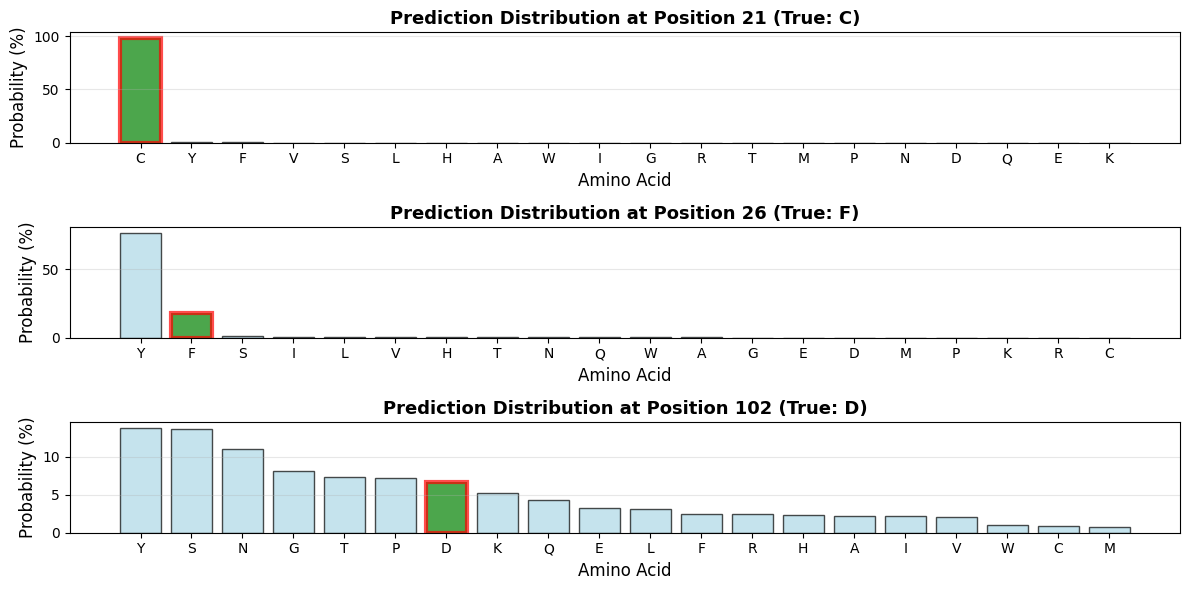

In [13]:
# Visualize prediction distribution for each position

fig, axes = plt.subplots(figsize=(12, 6), nrows=3)

for row,example_pos in enumerate(test_positions):
    probs = predict_masked_position(model, tokenizer, test_seq, example_pos)
    sorted_probs = sorted(probs.items(), key=lambda x: x[1], reverse=True)

    aas = [x[0] for x in sorted_probs]
    prob_values = [x[1]*100 for x in sorted_probs]
    colors = ['green' if aa == test_seq[example_pos] else 'lightblue' for aa in aas]

    bars = axes[row].bar(aas, prob_values, color=colors, edgecolor='black', alpha=0.7)
    axes[row].set_xlabel('Amino Acid', fontsize=12)
    axes[row].set_ylabel('Probability (%)', fontsize=12)
    axes[row].set_title(f'Prediction Distribution at Position {example_pos} (True: {test_seq[example_pos]})',
                fontsize=13, fontweight='bold')
    axes[row].grid(axis='y', alpha=0.3)

    # Highlight the true amino acid
    true_idx = aas.index(test_seq[example_pos])
    bars[true_idx].set_linewidth(3)
    bars[true_idx].set_edgecolor('red')

plt.tight_layout()
plt.show()


In [ ]:
import gc
gc.collect()